<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 3b. OCR Pipelines

Today, many large language model (LLM) systems can derive insights from various media such as news articles and academic papers. Both of these sources contain multimodal data such as text, figures, and tables. This tutorial provides a step-by-step guide showing how to isolate different modalities from multimodal PDF documents. The process of analyzing text in images is called Optical Character Recognition, or OCR. Let's create a multimodal pipeline with OCR and other PDF data extraction techniques to be used in a pipeline for LLM models. When an LLM retrieves information from such a pipeline, it's called retrieval augmented generation, or RAG.

<img src="images/DLI_extract.png" width="600">

In this tutorial, we will be using the open-source [unstructured](https://github.com/Unstructured-IO/unstructured) library for pre-processing images, tables and text from PDF documents.


#### Learning Objectives

The goals of this notebook are to:
* Explore Text Chunking
* Explore Table Extraction
* Explore Images/Plots Extraction
* Explore Identifying page elements with YOLOX-L
* Create an End-to-End Multimodal Data Extraction Pipeline

Let's load some libraries to get started.

In [1]:
import os
import getpass
import ipyplot
import requests
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image as IPyImage
from IPython.display import IFrame

from pathlib import Path

IMG_DIR = "ocr/images"

## 3.1 Setup

In this example, we will use the NVIDIA GB200 NVL72 white paper. It contains tables, plots, images and text description. Run the cell below to take a look.

In [2]:
filename = "data/grace-blackwell-datasheet.pdf"
IFrame(filename, width=800, height=500)

Let's segment the PDF document using unstructured's `partition_pdf` function and extract the text. Optical Character Recognition (OCR) will be used on images when the text is not already available in the PDF format. This library relies on the [Tesseract OCR](https://github.com/tesseract-ocr/tesseract) tool.

In [3]:
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Text, Image, Table, CompositeElement

We can use `partition_pdf` directly on the pdf file to extract useful elements. Each element is a section of text.

In [4]:
elements = partition_pdf(filename)
print("Retrieved elements: ", len(elements))

Retrieved elements:  154


To get a sense of what these elements look like, let's print each element and its corresponding page number.

In [5]:
for el in elements:
    if isinstance(el, Text):
        print("page ", el.metadata.page_number)
        print(el.text.strip())

page  1
Datasheet
page  1
NVIDIA GB200 NVL72 Powering the new era of computing.
page  1
Unlocking Real-Time Trillion-Parameter Models
page  1
NVIDIA GB200 NVL72 connects 36 Grace CPUs and 72 Blackwell GPUs in an NVIDIA®
page  1
NVLink®-connected, liquid-cooled, rack-scale design. Acting as a single, massive GPU, it
page  1
delivers 30X faster real-time trillion-parameter large language model (LLM) inference.
page  1
The GB200 Grace Blackwell Superchip is a key component of the NVIDIA GB200 NVL72, connecting two high-performance NVIDIA Blackwell GPUs and an NVIDIA Grace CPU with the NVLink-C2C interconnect.
page  1
Real-Time LLM Inference
page  1
HGX H1003.530X
page  1
116GB200 NVL7202060100120
page  1
Output Tokens per Second per GPU4080
page  1
GB200 NVL72 introduces cutting-edge capabilities and a second-generation
page  1
Transformer Engine, which enables FP4 AI and, when coupled with fifth-generation
page  1
NVLink, delivers 30X faster real-time inference performance for trillion-p

## 3.2 Explore Text Chunking

Text chunking involves transforming the text data from the PDF into smaller chunks that can be embedded and stored for later retrieval. The library provides a naive chunking strategy based on chunk size parameters (max characters). This method is purely syntactic and can limit the performance of the RAG pipeline if the chunks are not semantically distinct enough.  

There is a more granular chunking strategy `by_title` where section boundaries are preserved and we can split the text into more semantically distinct chunks. Let's check the granular chunking strategy:

In [6]:
granular_elements = partition_pdf(
    filename,
    chunking_strategy="by_title",
    max_characters=2000,
    new_after_n_chars=1800,
    combine_text_under_n_chars=1000,
)

First, let's check how many text sections are detected:

In [7]:
# check how many text section detected
print("Retrieved granular elements: ", len(granular_elements))

Retrieved granular elements:  6


Next, let's compare the first extracted section for both methods:

In [8]:
# let's compare extracted section 1 for both methods
print("Naive chunking method: \t", elements[0].text.strip()[:200], end="\n\n")
print("Granular chunking method: \t", granular_elements[0].text.strip()[:200], "...")

Naive chunking method: 	 Datasheet

Granular chunking method: 	 Datasheet

NVIDIA GB200 NVL72 Powering the new era of computing.

Unlocking Real-Time Trillion-Parameter Models

NVIDIA GB200 NVL72 connects 36 Grace CPUs and 72 Blackwell GPUs in an NVIDIA®

NVLink®- ...


The granular chunking method has extracted and grouped together the same sections of text from the PDF. This should help the retrieval process of our OCR pipeline.

## 3.3 Explore Table Extraction
The [unstructured](https://unstructured.io/) library uses the transformer-based object detection model [microsoft/table-transformer-structure-recognition](https://huggingface.co/microsoft/table-transformer-structure-recognition) to extract tables from PDFs.

To enable this, we will need to specify `infer_table_structure` as True.

<div class="alert alert-warning">Running the next cell can take about ~22s</div>

In [9]:
%%time
table_text_elements = partition_pdf(
    filename, infer_table_structure=True, strategy="hi_res"
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

CPU times: user 1min 8s, sys: 2.09 s, total: 1min 10s
Wall time: 14.7 s


The `text_as_html` element metadata attribute allows us to directly view the elements corresponding HTML.

In [10]:
for el in table_text_elements:
    if type(el) == Table:
        print("Table")
        print(el.metadata.text_as_html) 
        el_html = el.metadata.text_as_html

Table
<table><thead><tr><th rowspan="2">Configuration</th><th>36 Grace CPUs,</th><th>2 Grace CPUs,</th><th>1 Grac e CPU,</th></tr><tr><th>72 Blackwell GPUs</th><th>2 Blackwell GPUs</th><th>2 Blackwell GPUs</th></tr></thead><tbody><tr><td>FP4 Tensor Core?</td><td>1,440 PFLOPS</td><td>40 PFLOPS</td><td>40 PFLOPS</td></tr><tr><td>FP8/FP6 Tensor Core?</td><td>720 PFLOPS</td><td>20 PFLOPS</td><td>20 PFLOPS</td></tr><tr><td>INT8 Tensor Core?</td><td>720 POPS</td><td>20 POPS</td><td>20 POPS</td></tr><tr><td>FP16/BF 16 Tensor Core?</td><td>360 PFLOPS</td><td>10 PFLOPS</td><td>10 PFLOPS</td></tr><tr><td>TF32 Tensor Core?</td><td>180 TFLOPS</td><td>5 PFLOPS</td><td>5 PFLOPS</td></tr><tr><td>FP32</td><td>6,480 TFLOPS</td><td>180 TFLOPS</td><td>180 TFLOPS</td></tr><tr><td>FP64</td><td>3,240 TFLOPS</td><td>90 TFLOPS</td><td>90 TFLOPS</td></tr><tr><td>FP64 Tensor Core</td><td>3,240 TFLOPS</td><td>90 TFLOPS</td><td>90 TFLOPS</td></tr><tr><td>GPU Memory | Bandwidth</td><td>Up to 13.5TB HBMBe | 576TB/s

We can then convert this information into html data which can then be ingested by the [LangChain](https://python.langchain.com/docs/introduction/) framework, a popular framework used to make LLM applications.

In [11]:
from langchain.docstore.document import Document

table_elements = [
    Document(
        page_content=e.metadata.text_as_html,
        metadata={"filename": e.metadata.filename, "source_type": "table_html"},
    )
    for e in table_text_elements
    if type(e) == Table
]

# check first element
table_elements[0].page_content

'<table><thead><tr><th rowspan="2">Configuration</th><th>36 Grace CPUs,</th><th>2 Grace CPUs,</th><th>1 Grac e CPU,</th></tr><tr><th>72 Blackwell GPUs</th><th>2 Blackwell GPUs</th><th>2 Blackwell GPUs</th></tr></thead><tbody><tr><td>FP4 Tensor Core?</td><td>1,440 PFLOPS</td><td>40 PFLOPS</td><td>40 PFLOPS</td></tr><tr><td>FP8/FP6 Tensor Core?</td><td>720 PFLOPS</td><td>20 PFLOPS</td><td>20 PFLOPS</td></tr><tr><td>INT8 Tensor Core?</td><td>720 POPS</td><td>20 POPS</td><td>20 POPS</td></tr><tr><td>FP16/BF 16 Tensor Core?</td><td>360 PFLOPS</td><td>10 PFLOPS</td><td>10 PFLOPS</td></tr><tr><td>TF32 Tensor Core?</td><td>180 TFLOPS</td><td>5 PFLOPS</td><td>5 PFLOPS</td></tr><tr><td>FP32</td><td>6,480 TFLOPS</td><td>180 TFLOPS</td><td>180 TFLOPS</td></tr><tr><td>FP64</td><td>3,240 TFLOPS</td><td>90 TFLOPS</td><td>90 TFLOPS</td></tr><tr><td>FP64 Tensor Core</td><td>3,240 TFLOPS</td><td>90 TFLOPS</td><td>90 TFLOPS</td></tr><tr><td>GPU Memory | Bandwidth</td><td>Up to 13.5TB HBMBe | 576TB/s</td>

Since this content is HTML, we can display it within this Jupiter notebook like we could on a web page.

In [12]:
# print the table as HTML
from IPython.core.display import HTML
from IPython.display import display
display(HTML(el_html))

Most of the table has been accurately extracted, but there are some missing rows. The table extraction performance could be improved using techniques such as converting the PDF to markdown format and using the markdown representation of the table for retrieval, or by extracting the table as an image, which we will look at next.

## 3.4 Explore Images/Plots Extraction

To extract images from a PDF, we can set `extract_images_in_pdf=True`. The `unstructured` library uses the [YOLOX](https://arxiv.org/pdf/2107.08430v2) model to detect images. YOLOX is an anchor-free version of YOLO (You Only Look Once), a one-shot object detection model series from Megvii Technology.

```
elements = partition(filename=filename,
                     strategy="hi-res",
                     hi_res_model_name="yolox")
```

<div class="alert alert-warning">Running the next cell can take about 12s.</div>

In [13]:
os.environ["UNSTRUCTURED_HI_RES_MODEL_NAME"] = "yolox"

In [14]:
image_text_elements = partition_pdf(
    filename=filename,                 
    strategy="hi_res",    
    hi_res_model_name="yolox",
    extract_images_in_pdf=True,                            
    extract_image_block_types=["Image"],          
    extract_image_block_to_payload=False,
    extract_image_block_output_dir=IMG_DIR
)

Let's check the outputs to verify images were extracted.

In [15]:
images = [e.metadata.image_path for e in image_text_elements if type(e) == Image]
print("list of extracted images:\n", images)

list of extracted images:
 ['ocr/images/figure-1-1.jpg', 'ocr/images/figure-1-2.jpg', 'ocr/images/figure-2-3.jpg', 'ocr/images/figure-2-4.jpg', 'ocr/images/figure-3-5.jpg', 'ocr/images/figure-4-6.jpg']


We can then create a function to visualize the extracted images:

In [16]:
def plot_images_from_folder(folder_path=None, image_files=None):
    if image_files == None:
        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    if image_files:
        ipyplot.plot_images(image_files, max_images=20, img_width=200, show_url=False)
    else:
        print("No images found in the specified folder.")

In [17]:
plot_images_from_folder(image_files=images)

We can also process tables using the YOLOX model. The tables will be extracted as images.

Use `extract_image_block_types = ["Table"]`
<div class="alert alert-warning">Running the next cell can take about 16s</div>

In [18]:
%%time
image_table_text_elements = partition_pdf(
    filename=filename,                 
    strategy="hi_res",    
    hi_res_model_name="yolox",
    infer_table_structure=True,
    extract_images_in_pdf=True,                            
    extract_image_block_types=["Image", "Table"],          
    extract_image_block_to_payload=False,                  
    extract_image_block_output_dir=IMG_DIR
)

CPU times: user 1min 11s, sys: 128 ms, total: 1min 11s
Wall time: 8.76 s


`unstructured` has a `elements_to_json` function that we can use to convert the table information into a [JSON](https://www.json.org/json-en.html) file.

In [19]:
from unstructured.staging.base import elements_to_json
tables = [e for e in image_table_text_elements if type(e) == Table]
elements_to_json(image_table_text_elements, filename=f"{filename}.json")

'[\n    {\n        "element_id": "53295da0d27b644623e4293b43a6c852",\n        "metadata": {\n            "coordinates": {\n                "layout_height": 2200,\n                "layout_width": 1700,\n                "points": [\n                    [\n                        1080.2,\n                        -2.9\n                    ],\n                    [\n                        1080.2,\n                        619.8\n                    ],\n                    [\n                        1702.9,\n                        619.8\n                    ],\n                    [\n                        1702.9,\n                        -2.9\n                    ]\n                ],\n                "system": "PixelSpace"\n            },\n            "file_directory": "data",\n            "filename": "grace-blackwell-datasheet.pdf",\n            "filetype": "application/pdf",\n            "image_path": "ocr/images/figure-1-1.jpg",\n            "languages": [\n                "eng"\n    

While the table information was extracted, it's hard to read in this format. We can instead view the table as an image.

In [20]:
plot_images_from_folder(folder_path=IMG_DIR)

## 3.5 Identifying Page Elements with NV-YOLOX

YOLOX-L is a version of YOLOX fine-tuned on 26,000 images from the Digital Corpora dataset, with annotations from Azure AI Document Intelligence. The model is trained to detect **tables**, **charts** and **titles** in documents. A chart is defined as a bar chart, line chart, or pie chart. Titles can be page titles, section titles, or table/chart titles.

Let's use the [nvidia/nv-yolox-page-elements-v1](https://build.nvidia.com/nvidia/nv-yolox-page-elements-v1) model to locate the bounding boxes of elements in a [PNG](https://en.wikipedia.org/wiki/PNG) file. The bounding box tells us the location of an element within an image. Let's use the below image as an example.

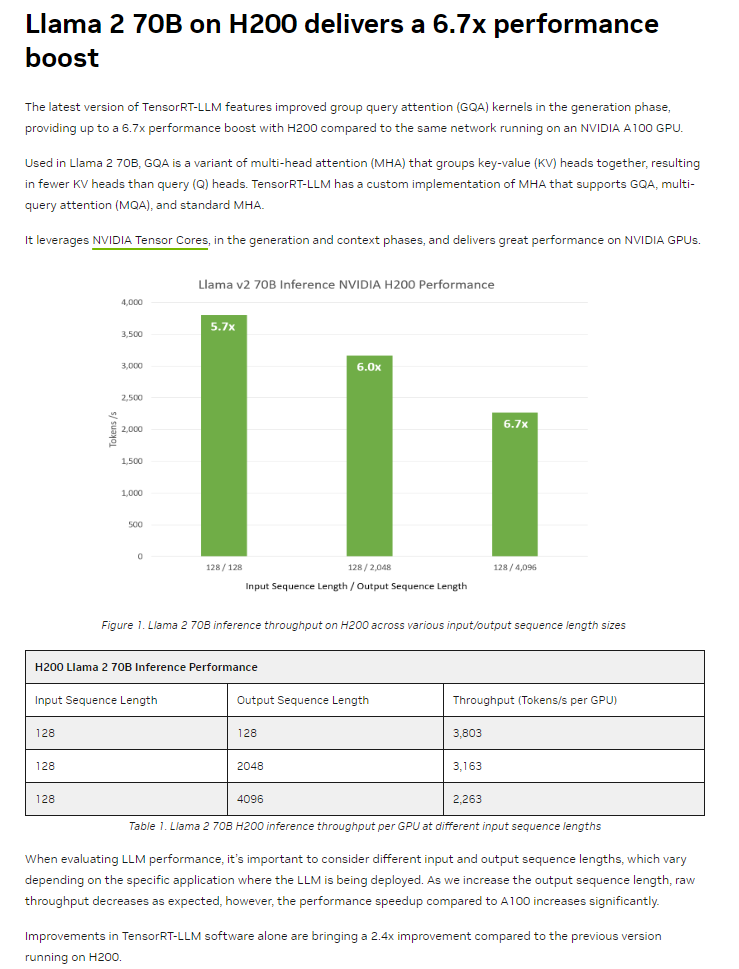

In [21]:
image_filename = "images/nvidia-tensorrt-llm-enhancements-deliver-massive-large-language-model-speedups-on-nvidia-h200.png"
IPyImage(filename=image_filename, width=600)

We can create a function that calls the YOLOX model API endpoint and returns the page elements with their precise locations on the page.

In [22]:
def run_yolox(filename):
    invoke_url = "http://ngc-client:9505/v1/cv/nvidia/nv-yolox-page-elements-v1"
    with open(filename, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
    assert len(image_b64) < 250_000, "To upload larger images, use the assets API (see docs)"
    
    headers = {
       "Authorization": "Bearer $API_KEY_REQUIRED_IF_EXECUTING_OUTSIDE_NGC",
       "Accept": "application/json"
    }
    
    payload = {
      "input": [
        {
          "type": "image_url",
          "url": f"data:image/png;base64,{image_b64}"
        }
      ]
    }
    
    response = requests.post(invoke_url, headers=headers, json=payload)
    print(response)
    bounding_boxes = response.json()['data'][0]['bounding_boxes']
    return bounding_boxes

Time to test it out. Let's use `run_yolox` on the image.

In [23]:
bounding_boxes = run_yolox(image_filename)

<Response [200]>


In [24]:
bounding_boxes

{'table': [{'x_min': 0.0267,
   'y_min': 0.6685,
   'x_max': 0.9557,
   'y_max': 0.8435,
   'confidence': 0.8835}],
 'chart': [{'x_min': 0.1439,
   'y_min': 0.2859,
   'x_max': 0.8052,
   'y_max': 0.6096,
   'confidence': 0.9387}],
 'title': [{'x_min': 0.0266,
   'y_min': 0.0102,
   'x_max': 0.8908,
   'y_max': 0.0549,
   'confidence': 0.8617}]}

Here, we can see the model identified 3 elements: a table, a chart, and a title.

Let's visualize those bounding boxes around the elements that were identified by the model:

In [25]:
# plotting function
def plot_bounding_boxes(image, bounding_boxes):
    annotated_image = image.copy()
    height, width = image.shape[:2]
    color = (128, 128, 128)
    labels = ['table', 'chart', 'title']   
    for l in labels:
        # check if label is identified
        if l not in bounding_boxes:
            continue
        T = bounding_boxes[l]
        for t in T:
            x_min = int(width * t['x_min'])
            y_min = int(height * t['y_min'])
            x_max = int(width * t['x_max'])
            y_max = int(height * t['y_max'])
            label = f"{l} {t['confidence']:.2f}"
            color = (0, 255, 0)  # Green color for the box
            cv2.rectangle(annotated_image, (x_min, y_min), (x_max, y_max), color, 2, cv2.LINE_AA)
            cv2.putText(annotated_image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, color=color, thickness=1)
    return annotated_image

We can draw the extracted bounding boxes and save them on a temporary image.

In [26]:
image = cv2.imread(image_filename)
annotated_image = plot_bounding_boxes(image, bounding_boxes)
OUTPUT_IMAGE_PATH = "ocr/outputs/yolox"

In [27]:
cv2.imwrite(OUTPUT_IMAGE_PATH + '/test_annotated.jpg', annotated_image)

True

Then, we can visualize the elements detected by `nv-yolox-page-elements-v1`:

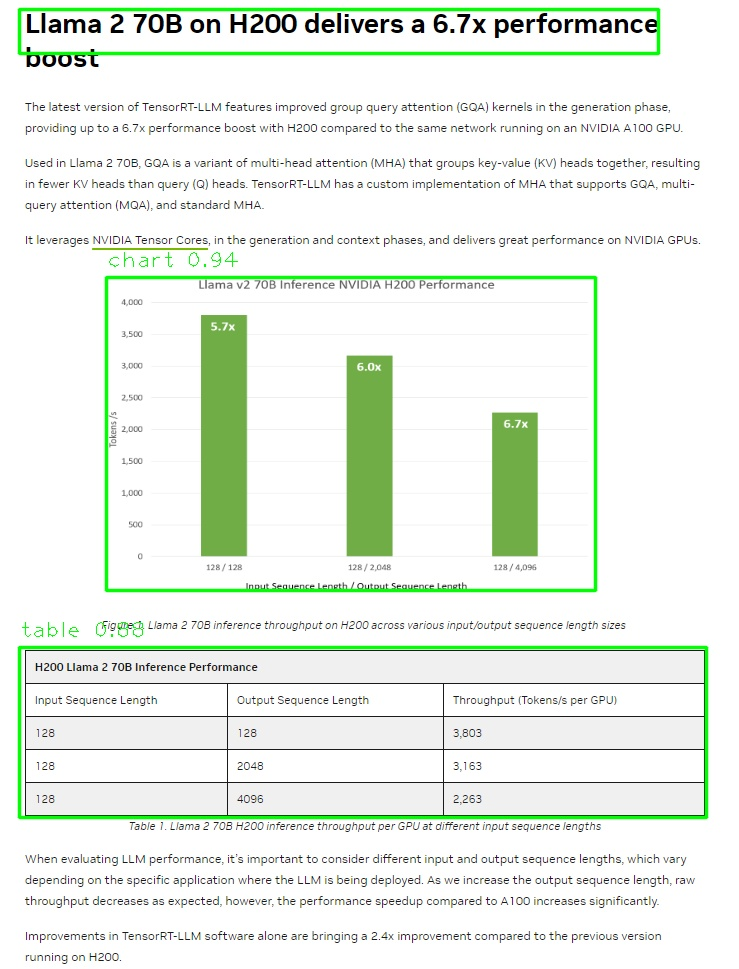

In [28]:
IPyImage(filename=OUTPUT_IMAGE_PATH + '/test_annotated.jpg', width=600)

## 3.5.1 Exercise: Bounding Boxes

Now let's try this with our original example NVIDIA GB200 NVL72 white paper from earlier.

First we need to convert each page of the PDF to an image. There are a couple ways to do this. We could process the entire PDF in one go by using `convert_from_path`, which loads all pages into memory at once:

```
from pdf2image import convert_from_path

pages = convert_from_path(filename, 500)
for count, page in enumerate(pages):
    page.save(f'pdf2image/out_{count}.jpg', 'JPEG')
```

However, this can consume significant memory, particularly for large PDFs and systems with limited RAM.

Instead, we can process the data using batching so that only a portion of the PDF is loaded into memory at a time. The `CHUNK_SIZE` can be adjusted based on available system resources to make processing more manageable.

In [29]:
from pdf2image import pdfinfo_from_path, convert_from_path

filename = "data/grace-blackwell-datasheet.pdf"
PATH_PDF2IMAGE = "ocr/outputs/pdf2image"

CHUNK_SIZE = 20  # depends on RAM
MAX_PAGES = pdfinfo_from_path(filename)["Pages"]

pages = []
for page in range(1, MAX_PAGES, CHUNK_SIZE):
    pages += convert_from_path(filename, first_page=page, last_page=page + CHUNK_SIZE - 1, dpi=100)

for count, page in enumerate(pages):
    page.save(f'{PATH_PDF2IMAGE}/test_{count}.jpg', 'JPEG')

Let's verify the image chunks were created:

In [30]:
!ls $PATH_PDF2IMAGE

test_0.jpg  test_1.jpg	test_2.jpg  test_3.jpg


Then, let's visualize the created chunks.

In [31]:
# Now let's visualize the pages
plot_images_from_folder(folder_path=PATH_PDF2IMAGE)

We can take one of these pages and compute the bounding boxes of the page elements.

In [32]:
bounding_boxes = run_yolox(PATH_PDF2IMAGE + "/test_2.jpg")
image = cv2.imread(PATH_PDF2IMAGE + "/test_2.jpg")   
annotated_image = plot_bounding_boxes(image, bounding_boxes)
cv2.imwrite(OUTPUT_IMAGE_PATH + '/annotated_test_1.jpg', annotated_image)

<Response [200]>


True

And we can visualize the identified titles and chart:

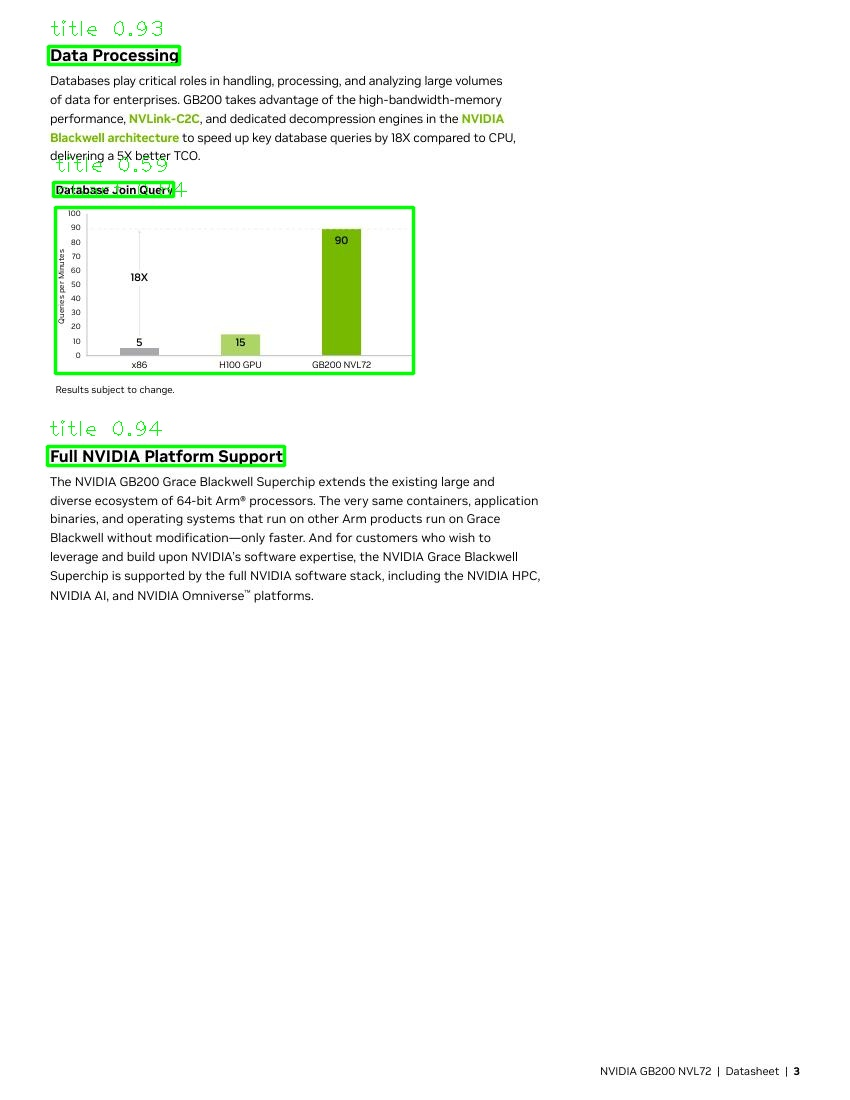

In [33]:
IPyImage(filename=OUTPUT_IMAGE_PATH + '/annotated_test_1.jpg', width=600)

If you encounter any issues, refer to the prepared folder `TMP_PATH_PDF2IMAGE` by running the next cell.

## 3.6 End-to-End Multimodal Data Extraction

Now we've looked at several different methods for pre-processing multimodal PDFs, we can try another end-to-end example.

Here we have a technical paper [ChipNemo](https://arxiv.org/pdf/2311.00176):

In [34]:
IFrame("ocr/pdfs/ChipNeMo.pdf", width=800, height=500)

The PDF contains a mixture of text under different sections, figures, tables, and graphs.

If we have a folder of PDFs, we will need to define a method to process each one. We can process the PDFs with different chunking strategies using [partition_pdf](https://docs.unstructured.io/api-reference/partition/partitioning).

In [35]:
class ExtractionPipeline:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.pdf_filenames = self.get_pdf_filenames_from_folder()        

    def get_pdf_filenames_from_folder(self):
        return list(Path(self.folder_path).glob("*.pdf"))

    def load_and_split_documents(self):
        for pdf_filename in self.pdf_filenames:
            print("processing document: ", pdf_filename)
            raw_pdf_elements = partition_pdf(
                pdf_filename, 
                infer_table_structure=True, 
                strategy='hi_res'
            )
            Text_elements = [Document(page_content=e.text.strip(), metadata={"filename": e.metadata.filename, "source_type": "text"}) for e in raw_pdf_elements if type(e) == Text or CompositeElement]
            print("Number of Detected Text elements: ", len(Text_elements))

            # Tables
            Table_elements = [Document(page_content=e.metadata.text_as_html, metadata={"filename": e.metadata.filename, "source_type": "table_html"}) for e in raw_pdf_elements if type(e) == Table]
            print("Number of Detected HTML Tables: ", len(Table_elements))
        return Text_elements, Table_elements

Let's now call the extraction function. This will extract text and tables (in HTML format) from the PDFs in the folder using the `by_title` strategy. We've specified parameters such as `max_characters`, `new_after_n_chars`, and `combine_text_under_n_chars` to control the chunk sizes of the text elements.

In [36]:
PDF_FOLDER_PATH = "ocr/pdfs"
Extraction_pipeline = ExtractionPipeline(folder_path=PDF_FOLDER_PATH)

<div class="alert alert-warning">Running the next cell can take about 3mn.</div>

In [ ]:
%%time 
# 2min 42s if you use default, 2s if you use fast but you get only text (no tabular data)
Text_elements, Table_elements = Extraction_pipeline.load_and_split_documents()

processing document:  ocr/pdfs/ChipNeMo.pdf


Let's verify the results:

In [ ]:
Text_elements[0].page_content, Text_elements[0].metadata

In [ ]:
Table_elements[0].page_content, Table_elements[0].metadata

Finally, we can [pickle](https://docs.python.org/3/library/pickle.html) our extracted data to be stored in our hypothetical RAG database.

In [ ]:
# save text and HTML tables 
import pickle

PATH_DATA = "ocr/outputs/data_dir_extracted"

with open(PATH_DATA + '/tables_db.pkl', 'wb') as fp:
    pickle.dump(Table_elements, fp)

with open(PATH_DATA + '/text_db.pkl', 'wb') as fp:
    pickle.dump(Text_elements, fp)

After saving all the text and table information from the paper, we can look at the `high_res` chunking strategy for comparison.

In [ ]:
class VisualExtractionPipeline:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.pdf_filenames = self.get_pdf_filenames_from_folder()        

    def get_pdf_filenames_from_folder(self):
        return list(Path(self.folder_path).glob("*.pdf"))

    def load_and_split_documents(self):
        for pdf_filename in self.pdf_filenames:
            print("processing document: ", pdf_filename)
            image_text_elements = partition_pdf(
                filename=pdf_filename,                 
                strategy="hi_res",    
                hi_res_model_name="yolox",
                extract_images_in_pdf=True,                            
                extract_image_block_types=["Image"],          
                extract_image_block_to_payload=False,                  
                extract_image_block_output_dir="ocr/figures"
            )
        image_elements = [Document(page_content=e.metadata.image_path, metadata={"filename": e.metadata.filename, "source_type": "image"}) for e in image_text_elements if type(e) == Image]
        #table_elements = [Document(page_content=e.metadata.image_path, metadata={"filename": e.metadata.filename, "source_type": "image_table"}) for e in image_text_elements if type(e) == Table]
        return image_elements  # + table_elements

<div class="alert alert-warning">Running the next cell can take about 2-3mn.</div>

In [ ]:
%%time
Extraction_pipeline_visual = VisualExtractionPipeline(folder_path=PDF_FOLDER_PATH)
image_elements = Extraction_pipeline_visual.load_and_split_documents()

Finally, let's see the images we have extracted from the PDF:

In [ ]:
images = [e.page_content for e in image_elements]
plot_images_from_folder(image_files=images)

As before, we can save our data in our hypothetical database.

In [ ]:
# save text and HTML tables 
import pickle

PATH_DATA = "ocr/outputs/data_dir_extracted"

with open(PATH_DATA + '/images_db.pkl', 'wb') as fp:
    pickle.dump(image_elements, fp)

## Next
Congrats on making it to the end!

In this notebook, we:
- Pre-processed multimodal PDFs using the *Unstructured* library, which is the first step for creating a multimodal RAG pipeline, and explored various functions to extract text, tables, images, and charts from PDFs.
- Explored NIMs components designed for multimodal content extraction to streamline the process.

In the next section of the course, we will use a completed Video Search and Summary (VSS) orchestrated pipeline. Let's learn more about it in the upcoming slide deck.

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>